## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import copy
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
import tslib.src.algorithms.tsUtils as tsUtils

## Parameters

In [3]:
N = 100 # Number of individuals (time series)
T = 100 # Number of time samples
t0 = 70 # Time of intervention
# Let us assume that there are 2 latent variables: u and v. 
m1 = 0 # Mean of distribution1
var1 = 0.5 # Variance of distribution1
m2 = 1 # Mean of distribution2
var2 = 0.7 # Variance of distribution2

u0 = np.random.normal(m1,var1,N) # Initial starting conditions of u
v0 = np.random.normal(m2,var2,N) # Initial starting conditions of v

In [4]:
def calculateW(u,v,z=0):
    a = 0.3 # Weight of variable u
    b = 0.6 # Weight of varialbe v
    c = 0.5 # Weight of variable z (only for treatment population)
    return a*u + b*v + c*z

## Data Generation

In [5]:
u = np.zeros((N,T)) # Time series of u
v = np.zeros((N,T)) # Time series of v
for idx in range(N):
    u[idx,0] = u0[idx]
    v[idx,0] = v0[idx]

# Add noise of u and v, representing a shift in time. 
for idx in range(N):
    for time in range(1,T):
        u[idx,time] = u[idx,time-1] + np.random.normal(0,0.05)
        v[idx,time] = v[idx,time-1] + np.random.normal(0,0.05)

# Define z, the intervention for individual n = 0.
# Let us hard code the initial starting value for z, z0. 
z0 = 2
# Now construct a time series for z, adding noise to z0.
z = np.zeros((N,T))
z[0,t0] = z0
for idx in range(t0+1,T):
    z[0,idx] = z[0,idx - 1] + np.random.normal(0,0.05)
    
W = np.zeros((N,T))
for idx in range(N):
    for time in range(T):
        W[idx,time] = calculateW(u[idx,time],v[idx,time],z[idx,time])

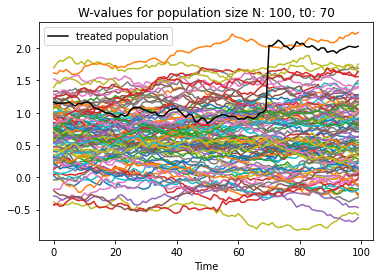

In [6]:
X = np.arange(0,T)
for idx in range(1,N):
    plt.plot(X,W[idx])
plt.plot(X,W[0],color='k',label = 'treated population')
plt.title("W-values for population size N: " + str(N) + ", t0: " + str(t0))
plt.xlabel("Time")
plt.legend()
plt.show()

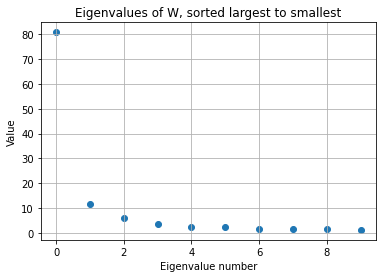

In [7]:
U, S, V = np.linalg.svd(W)
X = np.arange(10)
plt.title("Eigenvalues of W, sorted largest to smallest")
plt.xlabel("Eigenvalue number")
plt.ylabel("Value")
plt.scatter(X,S[:10])
plt.grid()
plt.show()

## Robust Synthetic Control

In [8]:
all_trajectories = np.arange(0,N)
donor_trajectories = np.arange(1,N)

trainingTimes = np.arange(0,t0)
testingTimes = np.arange(t0,T)

train_master_dict = {}
train_dict = {}
test_dict = {}

for row in all_trajectories:
    series = W[row]
    train_master_dict.update({row:series[trainingTimes]})

    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(train_master_dict[row]),1)
    train_dict.update({row:trainData})
    test_dict.update({row:series[testingTimes]})
series = W[0]
train_master_dict.update({0:series[trainingTimes]})
train_dict.update({0:series[trainingTimes]})
test_dict.update({0:series[testingTimes]})

train_master_df = pd.DataFrame(data = train_master_dict)
train_df = pd.DataFrame(data = train_dict)
test_df = pd.DataFrame(data = test_dict)
rscModel = RobustSyntheticControl(0,3,len(train_df),probObservation=1.0,modelType='svd',\
                                  svdMethod='numpy',otherSeriesKeysArray=donor_trajectories)
rscModel.fit(train_df)
denoised_df = rscModel.model.denoisedDF()

predictions = np.dot(test_df[donor_trajectories], rscModel.model.weights)
actual = W[0]
model_fit = np.dot(train_df[donor_trajectories][:],rscModel.model.weights)

## Treatment Recovery

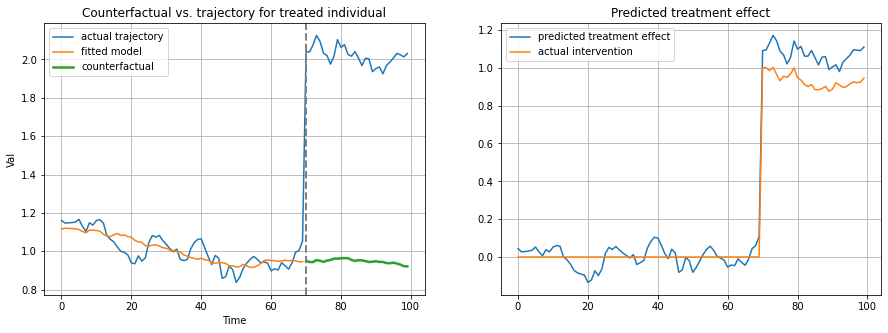

In [9]:
years = np.arange(0,T)

fig, ax = plt.subplots(1,2)
tick_spacing = 5
years = np.arange(0,T)
fig.set_size_inches(15, 5)

#ax[0].set_xticks(np.arange(t)
#ax[0].set_xticklabels(years, rotation = 45)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax[0].plot(years,actual,label='actual trajectory')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Val')
ax[0].set_title("Counterfactual vs. trajectory for treated individual")
ax[1].set_title("Predicted treatment effect")
ax[0].plot(trainingTimes,model_fit,label='fitted model')
ax[0].plot(testingTimes,predictions,label='counterfactual',linewidth=2.5)

ax[0].axvline(x=t0,color='grey',linestyle='--',linewidth=2)
ax[0].grid()
ax[0].legend()

#ax[1].set_xticks(np.arange(t))
#ax[1].set_xticklabels(years, rotation = 45)
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Val')
#ax[1].set_title('Treatment Effect')


difference = np.zeros((T))
for idx in trainingTimes:
    difference[idx] = actual[idx] - model_fit[idx]
    
for idx in testingTimes:
    difference[idx] = actual[idx] - predictions[idx-t0]
    
X = np.arange(0,T)
ax[1].plot(X,difference, label='predicted treatment effect')

actual_treatment = np.zeros(T)
for idx in range(T):
    actual_treatment[idx] = calculateW(u=0,v=0,z=z[0,idx])
ax[1].plot(X,actual_treatment,label='actual intervention')

plt.grid()
plt.legend()
plt.show()

In [26]:
def loss(actual, estimate):
    return abs(actual - estimate)

In [29]:
def meanSquaredError(actual, estimate):
    res = 0
    for idx in (0,actual.size-1):
        res = res + loss(actual[idx],estimate[idx]) * loss(actual[idx],estimate[idx])
    return (res / actual.size)

## Evaluate Causal Inference

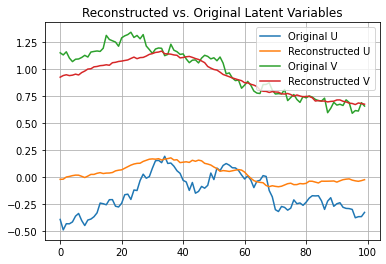

In [39]:
# Now we are trying to recover the latent variables from the output.
# We use the weights from the robust synthetic control algorithm and apply them to 
# the original u and v matrices, and see if we can recover z that way as well.

reconstructedU = np.dot(rscModel.model.weights,u[1:,:])
reconstructedV = np.dot(rscModel.model.weights,v[1:,:])

plt.title("Reconstructed vs. Original Latent Variables")
plt.plot(X,u[0],label='Original U')
plt.plot(X,reconstructedU,label='Reconstructed U')
plt.plot(X,v[0],label='Original V')
plt.plot(X,reconstructedV,label='Reconstructed V')
plt.grid()
plt.legend()
plt.show()

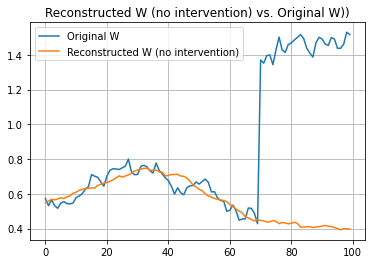

In [47]:
plt.title("Reconstructed W (no intervention) vs. Original W))")
plt.plot(X,W[0], label='Original W')
plt.plot(X,calculateW(reconstructedU, reconstructedV), label='Reconstructed W (no intervention)')
plt.grid()
plt.legend()
plt.show()

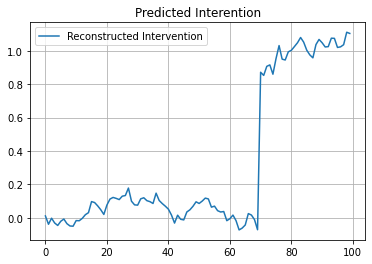

In [50]:
plt.title("Predicted Interention")
plt.plot(X,W[0]-calculateW(-reconstructedU,reconstructedV),label='Reconstructed Intervention')
plt.grid()
plt.legend()
plt.show()

In [34]:
print("Loss, U: " + str(round(meanSquaredError(reconstructedU, u[0]),5)))
print("Loss, V: " + str(round(meanSquaredError(reconstructedV, v[0]),5)))

Loss, U: 0.00231
Loss, V: 0.00051


## Causal Inference on Polynomial Observations

In [11]:
# Here, we will see if this works even when W is calculated as a linear combination of u^2 and v^3.
def exponentialW(u,v,z=0):
    a = 0.3 # Weight of variable u
    b = 0.6 # Weight of varialbe v
    c = 0.5 # Weight of variable z (only for treatment population)
    return a*u*u + b*v*v*v + c*z

In [12]:
N = 100 # Number of individuals (time series)
T = 100 # Number of time samples
t0 = 70 # Time of intervention
# Let us assume that there are 2 latent variables: u and v. 
m1 = 0 # Mean of distribution1
var1 = 0.5 # Variance of distribution1
m2 = 1 # Mean of distribution2
var2 = 0.7 # Variance of distribution2

u0 = np.random.normal(m1,var1,N) # Initial starting conditions of u
v0 = np.random.normal(m2,var2,N) # Initial starting conditions of v

u = np.zeros((N,T)) # Time series of u
v = np.zeros((N,T)) # Time series of v
for idx in range(N):
    u[idx,0] = u0[idx]
    v[idx,0] = v0[idx]

# Add noise fo u and v, representing a shift in time. 
for idx in range(N):
    for time in range(1,T):
        u[idx,time] = u[idx,time-1] + np.random.normal(0,0.05)
        v[idx,time] = v[idx,time-1] + np.random.normal(0,0.05)

# Define z, the intervention for individual n = 0.
# Let us hard code the initial starting value for z, z0. 
z0 = 2
# Now construct a time series for z, adding noise to z0.
z = np.zeros((N,T))
z[0,t0] = z0
for idx in range(t0+1,T):
    z[0,idx] = z[0,idx - 1] + np.random.normal(0,0.05)
    
W = np.zeros((N,T))
for idx in range(N):
    for time in range(T):
        W[idx,time] = exponentialW(u[idx,time],v[idx,time],z[idx,time])

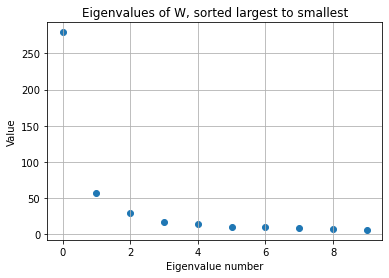

In [13]:
U, S, V = np.linalg.svd(W)
X = np.arange(10)
plt.title("Eigenvalues of W, sorted largest to smallest")
plt.xlabel("Eigenvalue number")
plt.ylabel("Value")
plt.scatter(X,S[:10])
plt.grid()
plt.show()

In [14]:
all_trajectories = np.arange(0,N)
donor_trajectories = np.arange(1,N)

trainingTimes = np.arange(0,t0)
testingTimes = np.arange(t0,T)

train_master_dict = {}
train_dict = {}
test_dict = {}

for row in all_trajectories:
    series = W[row]
    train_master_dict.update({row:series[trainingTimes]})

    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(train_master_dict[row]),1)
    train_dict.update({row:trainData})
    test_dict.update({row:series[testingTimes]})
series = W[0]
train_master_dict.update({0:series[trainingTimes]})
train_dict.update({0:series[trainingTimes]})
test_dict.update({0:series[testingTimes]})

train_master_df = pd.DataFrame(data = train_master_dict)
train_df = pd.DataFrame(data = train_dict)
test_df = pd.DataFrame(data = test_dict)
rscModel = RobustSyntheticControl(0,3,len(train_df),probObservation=1.0,modelType='svd',\
                                  svdMethod='numpy',otherSeriesKeysArray=donor_trajectories)
rscModel.fit(train_df)
denoised_df = rscModel.model.denoisedDF()

predictions = np.dot(test_df[donor_trajectories], rscModel.model.weights)
actual = W[0]
model_fit = np.dot(train_df[donor_trajectories][:],rscModel.model.weights)

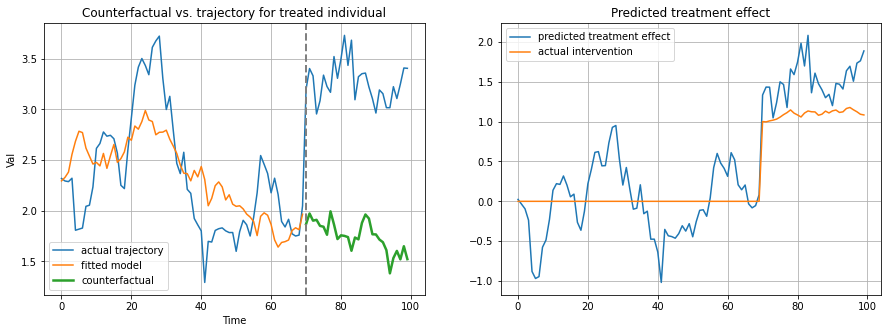

In [16]:
years = np.arange(0,T)

fig, ax = plt.subplots(1,2)
tick_spacing = 5
years = np.arange(0,T)
fig.set_size_inches(15, 5)

#ax[0].set_xticks(np.arange(t)
#ax[0].set_xticklabels(years, rotation = 45)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax[0].plot(years,actual,label='actual trajectory')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Val')
ax[0].set_title("Counterfactual vs. trajectory for treated individual")
ax[1].set_title("Predicted treatment effect")
ax[0].plot(trainingTimes,model_fit,label='fitted model')
ax[0].plot(testingTimes,predictions,label='counterfactual',linewidth=2.5)

ax[0].axvline(x=t0,color='grey',linestyle='--',linewidth=2)
ax[0].grid()
ax[0].legend()

#ax[1].set_xticks(np.arange(t))
#ax[1].set_xticklabels(years, rotation = 45)
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Val')
#ax[1].set_title('Treatment Effect')


difference = np.zeros((T))
for idx in trainingTimes:
    difference[idx] = actual[idx] - model_fit[idx]
    
for idx in testingTimes:
    difference[idx] = actual[idx] - predictions[idx-t0]
    
X = np.arange(0,T)
ax[1].plot(X,difference, label='predicted treatment effect')

actual_treatment = np.zeros(T)
for idx in range(T):
    actual_treatment[idx] = exponentialW(u=0,v=0,z=z[0,idx])
ax[1].plot(X,actual_treatment,label='actual intervention')

plt.grid()
plt.legend()
plt.show()

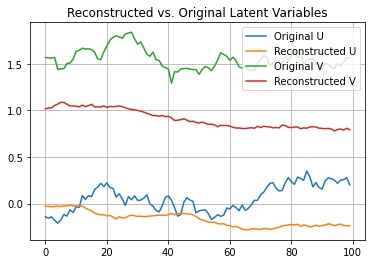

In [17]:
# Now we are trying to recover the latent variables from the output.
# We use the weights from the robust synthetic control algorithm and apply them to 
# the original u and v matrices, and see if we can recover z that way as well.

reconstructedU = np.dot(rscModel.model.weights,u[1:,:])
reconstructedV = np.dot(rscModel.model.weights,v[1:,:])

plt.title("Reconstructed vs. Original Latent Variables")
plt.plot(X,u[0],label='Original U')
plt.plot(X,reconstructedU,label='Reconstructed U')
plt.plot(X,v[0],label='Original V')
plt.plot(X,reconstructedV,label='Reconstructed V')
plt.grid()
plt.legend()
plt.show()

## Causal Inference on Power Observations

In [27]:
# Here, we will see if this works even when W is calculated as a binomial.
def powerW(u,v,z=0):
    a = 0.3 # Weight of variable u
    b = 0.6 # Weight of varialbe v
    c = 0.5 # Weight of variable z (only for treatment population)
    return a*pow(2,u) + b*pow(2,v) + c*pow(2,z)

In [28]:
N = 100 # Number of individuals (time series)
T = 100 # Number of time samples
t0 = 70 # Time of intervention
# Let us assume that there are 2 latent variables: u and v. 
m1 = 0 # Mean of distribution1
var1 = 0.5 # Variance of distribution1
m2 = 1 # Mean of distribution2
var2 = 0.7 # Variance of distribution2

u0 = np.random.normal(m1,var1,N) # Initial starting conditions of u
v0 = np.random.normal(m2,var2,N) # Initial starting conditions of v

u = np.zeros((N,T)) # Time series of u
v = np.zeros((N,T)) # Time series of v
for idx in range(N):
    u[idx,0] = u0[idx]
    v[idx,0] = v0[idx]

# Add noise fo u and v, representing a shift in time. 
for idx in range(N):
    for time in range(1,T):
        u[idx,time] = u[idx,time-1] + np.random.normal(0,0.05)
        v[idx,time] = v[idx,time-1] + np.random.normal(0,0.05)

# Define z, the intervention for individual n = 0.
# Let us hard code the initial starting value for z, z0. 
z0 = 2
# Now construct a time series for z, adding noise to z0.
z = np.zeros((N,T))
z[0,t0] = z0
for idx in range(t0+1,T):
    z[0,idx] = z[0,idx - 1] + np.random.normal(0,0.05)
    
W = np.zeros((N,T))
for idx in range(N):
    for time in range(T):
        W[idx,time] = powerW(u[idx,time],v[idx,time],z[idx,time])

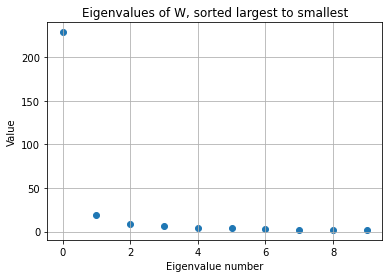

In [29]:
U, S, V = np.linalg.svd(W)
X = np.arange(10)
plt.title("Eigenvalues of W, sorted largest to smallest")
plt.xlabel("Eigenvalue number")
plt.ylabel("Value")
plt.scatter(X,S[:10])
plt.grid()
plt.show()

In [30]:
all_trajectories = np.arange(0,N)
donor_trajectories = np.arange(1,N)

trainingTimes = np.arange(0,t0)
testingTimes = np.arange(t0,T)

train_master_dict = {}
train_dict = {}
test_dict = {}

for row in all_trajectories:
    series = W[row]
    train_master_dict.update({row:series[trainingTimes]})

    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(train_master_dict[row]),1)
    train_dict.update({row:trainData})
    test_dict.update({row:series[testingTimes]})
series = W[0]
train_master_dict.update({0:series[trainingTimes]})
train_dict.update({0:series[trainingTimes]})
test_dict.update({0:series[testingTimes]})

train_master_df = pd.DataFrame(data = train_master_dict)
train_df = pd.DataFrame(data = train_dict)
test_df = pd.DataFrame(data = test_dict)
rscModel = RobustSyntheticControl(0,3,len(train_df),probObservation=1.0,modelType='svd',\
                                  svdMethod='numpy',otherSeriesKeysArray=donor_trajectories)
rscModel.fit(train_df)
denoised_df = rscModel.model.denoisedDF()

predictions = np.dot(test_df[donor_trajectories], rscModel.model.weights)
actual = W[0]
model_fit = np.dot(train_df[donor_trajectories][:],rscModel.model.weights)

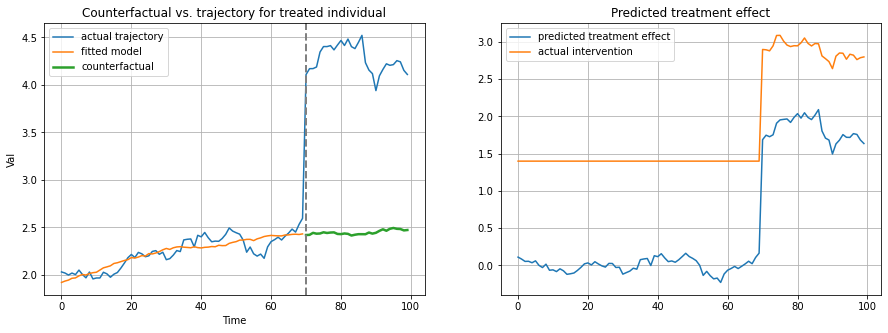

In [31]:
years = np.arange(0,T)

fig, ax = plt.subplots(1,2)
tick_spacing = 5
years = np.arange(0,T)
fig.set_size_inches(15, 5)

#ax[0].set_xticks(np.arange(t)
#ax[0].set_xticklabels(years, rotation = 45)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax[0].plot(years,actual,label='actual trajectory')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Val')
ax[0].set_title("Counterfactual vs. trajectory for treated individual")
ax[1].set_title("Predicted treatment effect")
ax[0].plot(trainingTimes,model_fit,label='fitted model')
ax[0].plot(testingTimes,predictions,label='counterfactual',linewidth=2.5)

ax[0].axvline(x=t0,color='grey',linestyle='--',linewidth=2)
ax[0].grid()
ax[0].legend()

#ax[1].set_xticks(np.arange(t))
#ax[1].set_xticklabels(years, rotation = 45)
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Val')
#ax[1].set_title('Treatment Effect')


difference = np.zeros((T))
for idx in trainingTimes:
    difference[idx] = actual[idx] - model_fit[idx]
    
for idx in testingTimes:
    difference[idx] = actual[idx] - predictions[idx-t0]
    
X = np.arange(0,T)
ax[1].plot(X,difference, label='predicted treatment effect')

actual_treatment = np.zeros(T)
for idx in range(T):
    actual_treatment[idx] = powerW(u=0,v=0,z=z[0,idx])
ax[1].plot(X,actual_treatment,label='actual intervention')

plt.grid()
plt.legend()
plt.show()